<a href="https://colab.research.google.com/github/sanxlop/stocks/blob/master/stocks_talib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install yfinance

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import talib
import seaborn as sns
%matplotlib inline
plt.style.use('dark_background')

In [0]:
def add_price_transforms(df):
    for ticker in tickers_desc.keys():
        df[ticker,'CHANGE'] = df[ticker,'Close'].diff()
        df[ticker,'CHANGE_PERCENT'] = df[ticker,'Close'].div(df[ticker,'Close'].shift(1))*100-100
        #df[ticker,'CHANGE_LABEL'] = df[ticker,'CHANGE'].apply(set_change_label)
        df[ticker,'AVGPRICE'] = talib.AVGPRICE(df[ticker,'Open'], df[ticker,'High'], df[ticker,'Low'], df[ticker,'Close']) # Average Price
        df[ticker,'MEDPRICE'] = talib.MEDPRICE(df[ticker,'High'], df[ticker,'Low']) # Median Price
        df[ticker,'TYPPRICE'] = talib.TYPPRICE(df[ticker,'High'], df[ticker,'Low'], df[ticker,'Close']) # Typical Price
        df[ticker,'WCLPRICE'] = talib.WCLPRICE(df[ticker,'High'], df[ticker,'Low'], df[ticker,'Close']) # Weighted Close Price
    return df

def add_overlap_functions(df):
    for ticker in tickers_desc.keys():
        df[ticker,'DEMA'] = talib.DEMA(df[ticker,'Close'], timeperiod=30) # Double Exponential Moving Average
        df[ticker,'EMA'] = talib.EMA(df[ticker,'Close'], timeperiod=30) # Exponential Moving Average
        df[ticker,'HT_TRENDLINE'] = talib.HT_TRENDLINE(df[ticker,'Close']) # Hilbert Transform - Instantaneous Trendline
        df[ticker,'KAMA'] = talib.KAMA(df[ticker,'Close'], timeperiod=30) # Kaufman Adaptive Moving Average
        df[ticker,'MA'] = talib.MA(df[ticker,'Close'], timeperiod=30, matype=0) # Moving average
        df[ticker,'MAMA_mama'], df[ticker,'MAMA_fama'] = talib.MAMA(df[ticker,'Close'], fastlimit=0.5, slowlimit=0.05) # MESA Adaptive Moving Average
        #df[ticker,'MAVP'] = talib.MAVP(df[ticker,'Close'], periods, minperiod=2, maxperiod=30, matype=0) # Moving average with variable period
        df[ticker,'MIDPOINT'] = talib.MIDPOINT(df[ticker,'Close'], timeperiod=14) # MidPoint over period
        df[ticker,'MIDPRICE'] = talib.MIDPRICE(df[ticker,'High'], df[ticker,'Low'], timeperiod=14) # Midpoint Price over period
        df[ticker,'SAR'] = talib.SAR(df[ticker,'High'], df[ticker,'Low'], acceleration=0.02, maximum=0.2) # Parabolic SAR
        df[ticker,'SAREXT'] = talib.SAREXT(df[ticker,'High'], df[ticker,'Low'], startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0) # Parabolic SAR - Extended
        df[ticker,'SMA'] = talib.SMA(df[ticker,'Close'], timeperiod=30) # Simple Moving Average
        df[ticker,'T3'] = talib.T3(df[ticker,'Close'], timeperiod=5, vfactor=0.7) # Triple Exponential Moving Average (T3)
        df[ticker,'TEMA'] = talib.TEMA(df[ticker,'Close'], timeperiod=30) # Triple Exponential Moving Average
        df[ticker,'TRIMA'] = talib.TRIMA(df[ticker,'Close'], timeperiod=30) # Triangular Moving Average
        df[ticker,'WMA'] = talib.WMA(df[ticker,'Close'], timeperiod=30) # Weighted Moving Average
    return df

def add_indicators_functions(df, timeperiod, config_limits):
    for ticker in tickers_desc.keys():
        df[ticker,'BB_up'], df[ticker,'BB_mid'], df[ticker,'BB_low'] = talib.BBANDS(df[ticker,'Close'].values, timeperiod=timeperiod, nbdevup=2, nbdevdn=2, matype=0) # MA_Type.SMA
        df[ticker,'BBP'] = (df[ticker,'Close'] - df[ticker,'BB_low']) / (df[ticker,'BB_up'] - df[ticker,'BB_low'])
        df[ticker,'RSI'] = talib.RSI(df[ticker,'Close'], timeperiod=timeperiod)
        
        df[ticker,'HOLDINGS'] = 0
        df.loc[((df[ticker,'RSI'] < config_limits.get('RSI_LOW_LIMIT')) & (df[ticker,'BBP'] < config_limits.get('BBP_LOW_LIMIT'))), (ticker,'HOLDINGS')] = df[ticker,'RSI']/100 # + price['BBP'])/2 # + Buy Green
        df.loc[((df[ticker,'RSI'] > config_limits.get('RSI_UP_LIMIT')) & (df[ticker,'BBP'] > config_limits.get('BBP_UP_LIMIT'))), (ticker,'HOLDINGS')] = -(df[ticker,'RSI']/100) # + price['BBP'])/2 # - Sell Red

        df[ticker,'BLOW_SHIGH'] = 0
        df.loc[(df[ticker,'Close'] < calc_num_low(df[ticker,'Close'], config_limits.get('BLOW_SHIGH_LOW'))), (ticker,'BLOW_SHIGH')] = calc_percent_low(df[ticker,'Close']) # + Buy Blue
        df.loc[(df[ticker,'Close'] > calc_num_high(df[ticker,'Close'], config_limits.get('BLOW_SHIGH_UP'))), (ticker,'BLOW_SHIGH')] = -calc_percent_high(df[ticker,'Close']) # - Sell Purple
    return df

def calc_num_low(df_column, percent_thr):
    low_percent = df_column.min() * 100 / df_column.max()
    admit_percent = low_percent + percent_thr
    low_number = df_column.max() * admit_percent / 100
    return low_number

def calc_num_high(df_column, percent_thr):
    high_percent = 100
    admit_percent = high_percent - percent_thr
    high_number = df_column.max() * admit_percent / 100
    return high_number

def calc_percent_low(df_column):
    return df_column.min() / df_column

def calc_percent_high(df_column):
    return df_column / df_column.max()

def plot_result(df, ticker, config_limits, tickers_desc):
    fig, (ax0, ax1, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 10))
    plt.suptitle(ticker+" "+ str(tickers_desc.get(ticker)))
    ax0.plot(df.index, df[ticker,'Close'], label='Close')
    ax0.set_xlabel('Date')
    ax0.set_ylabel('Close')
    ax0.grid()
    for day, holding in df[ticker].iterrows():
        order = holding['HOLDINGS']
        order2 = holding['BLOW_SHIGH']
        if order > 0: # + Buy Green
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='green', alpha=(1-order), s=(1-order)*100)
        elif order < 0: # - Sell Red
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='red', alpha=abs(order), s=abs(order)*100)

        if order2 > 0: # + Buy Blue
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='blue', alpha=1)
        elif order2 < 0: # - Sell Purple
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='purple', alpha=1)

    ax1.plot(df.index, df[ticker,'RSI'], label='RSI')
    ax1.fill_between(df.index, y1=config_limits.get('RSI_LOW_LIMIT'), y2=config_limits.get('RSI_UP_LIMIT'), color='#adccff', alpha=0.3)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RSI')
    ax1.grid()

    ax3.plot(df.index, df[ticker,'BBP'], label='BBP')
    ax3.fill_between(df.index, y1=config_limits.get('BBP_LOW_LIMIT'), y2=config_limits.get('BBP_UP_LIMIT'), color='#adccff', alpha=0.3)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('BBP')
    ax3.grid()

    # ax2.plot(df.index, df[ticker,'BB_up'], label='BB_up')
    # ax2.plot(df.index, df[ticker,'Close'], label='Close')
    # ax2.plot(df.index, df[ticker,'BB_low'], label='BB_low')
    # ax2.fill_between(df.index, y1=df[ticker,'BB_low'], y2=df[ticker,'BB_up'], color='#adccff', alpha=0.3)
    # ax2.set_xlabel('Date')
    # ax2.set_ylabel('Bollinger Bands')
    # ax2.grid()

    fig.tight_layout()
    plt.show()


In [0]:
tickers_desc = {'ACN': 'Accenture',
                'ATVI': 'Activision',
                'ADS': 'Adidas',
                'ADBE': 'Adobe_Inc',
                'BABA': 'Alibaba',
                'GOOG': 'Alphabet',
                'AMZN': 'Amazon.com',
                'AMD': 'AMD',
                'AAPL': 'Apple',
                'ASTC': 'Astrotech',
                'T': 'AT&T',
                'BIDU': 'Baidu',
                'SAN': 'Banco_Santander',
                'BBVA': 'BBVA',
                'BB': 'Blackberry',
                'BKNG': 'Booking_Holdings',
                'BP': 'BP',
                'CAIXY': 'Caixabank',
                'CHFS': 'CHF_Solutions',
                'CSCO': 'Cisco_Systems',
                'KO': 'Coca-Cola',
                'CCEP': 'Coca-Cola_Euro',
                'DPZ': 'Dominos_Piza',
                'EA': 'Electronic_Arts',
                'ERIC': 'Ericsson',
                'FB': 'Facebook',
                'F': 'Ford_Motor',
                'GE': 'GE',
                'IDEXY': 'Inditex',
                'INTC': 'Intel',
                'JPM': 'JPMorgan',
                'MA': 'Mastercard',
                'MCD': 'McDonalds',
                'MU': 'Micron_Tech',
                'MSFT': 'Microsoft',
                'NFLX': 'Netflix',
                'NKE': 'Nike',
                'NVDA': 'Nvidia',
                'ORCL': 'Oracle',
                'ORAN': 'Orange',
                'PYPL': 'PayPal',
                'PEP': 'PepsiCo',
                'PFE': 'Pfizer',
                'QCOM': 'Qualcomm',
                'RYAAY': 'Ryanair',
                'SNE': 'Sony',
                'SPOT': 'Spotify',
                'TEF': 'Telefonica',
                'TERP': 'TerraForm_Power',
                'TSLA': 'TESLA',
                'TM': 'Toyota',
                'TWTR': 'Twitter',           
                'UBER': 'Uber',
                'VRTX': 'Vertex_Pharmaceuticals',
                'VZ': 'Verizon',
                'V': 'Visa',
                'VOD': 'Vodafone_Group',
                'DIS': 'Walt_Disnet',
                'XIACY': 'XIAOMI',
                'ZM': 'ZOOM VIDEO',
              }

tickers_desc = {
              #https://www.morningstar.com/articles/976067/6-more-stocks-we-like
              'CLR': ['CONTINENTAL_RSRC','01/04/2020',7.47,19,'SusanDziubinski',np.nan,np.nan,np.nan],
              'CTL': ['CenturyLink','01/04/2020',8.79,18,'SusanDziubinski',np.nan,np.nan,np.nan],
              'VVV': ['Valvoline','01/04/2020',11.90,19.80,'SusanDziubinski',np.nan,np.nan,np.nan],
              'INGR': ['Ingredion','01/04/2020',75.54,125,'SusanDziubinski',np.nan,np.nan,np.nan],
              'TWNK': ['Hostess_Brands','01/04/2020',10.41,15.80,'SusanDziubinski',np.nan,np.nan,np.nan],
              #https://www.morningstar.com/articles/974962/healthcare-moves-into-undervalued-territory-after-pullback
              'PFE': ['Pfizer','26/03/2020',30,46,'DamienConover',np.nan,np.nan,np.nan],
              'ZBH': ['Zimmer_Biomet_Holdings','26/03/2020',91,178,'DamienConover',np.nan,np.nan,np.nan],
              'CVS': ['CSV_Health','26/03/2020',55,92,'DamienConover',np.nan,np.nan,np.nan],
              #https://www.morningstar.com/articles/974966/best-values-among-hardest-hit-real-estate-subsectors
              'SPG': ['Simon_Property_Group','26/03/2020',45,187,'KevinBrown',np.nan,np.nan,np.nan],
              'PEB': ['Pebblebrook_Hotel_Trust','26/03/2020',10,26.5,'KevinBrown',np.nan,np.nan,np.nan],
              'VTR': ['Ventas','26/03/2020',29,50,'KevinBrown',np.nan,np.nan,np.nan],
              #https://www.morningstar.com/articles/973345/5-more-stocks-we-like
              'CVE': ['Cenovus_Energy','19/03/2020',1.64,7,'SusanDziubinski',np.nan,np.nan,np.nan],
              'BUD': ['AB_Inbev','19/03/2020',36.36,96,'SusanDziubinski',np.nan,np.nan,np.nan],
              'CTVA': ['Corteva_19','19/03/2020',23.26,40,'SusanDziubinski',np.nan,np.nan,np.nan],
              'AXP': ['AmericanExpress','19/03/2020',77.07,125,'SusanDziubinski',np.nan,np.nan,np.nan],
              #https://www.morningstar.com/articles/972772/5-stocks-we-like
              'FANG': ['Diamondback_Energy','16/03/2020',23.49,90,'SusanDziubinski',np.nan,np.nan,np.nan],
              'FSLR': ['First_Solar','16/03/2020',31.54,59,'SusanDziubinski',np.nan,np.nan,np.nan],
              'SYY': ['Sysco','16/03/2020',37.75,59,'SusanDziubinski',np.nan,np.nan,np.nan],
              'CMCSA': ['Comcast','16/03/2020',36.04,49,'SusanDziubinski',np.nan,np.nan,np.nan],
              }

tickers_names = " ".join(tickers_desc.keys())

config_limits = {'RSI_LOW_LIMIT': 30,
                  'RSI_UP_LIMIT': 70,
                  'BBP_LOW_LIMIT': 0,
                  'BBP_UP_LIMIT': 1,
                  'BLOW_SHIGH_LOW': 2,
                  'BLOW_SHIGH_UP': 2,
                 }

In [165]:
"""Get data from yfinance"""
print(tickers_names)
hist_downloaded = yf.download(tickers_names, period="3mo", interval="1d", start=None, end=None, actions=False, rounding=True, group_by='ticker', threads=True)

CLR CTL VVV INGR TWNK PFE ZBH CVS SPG PEB VTR CVE BUD CTVA AXP FANG FSLR SYY CMCSA
[*********************100%***********************]  19 of 19 completed


In [190]:
df = pd.DataFrame (tickers_desc)
df = df.T
df = df.rename(columns={0: 'name', 1: 'inf_date', 2: 'inf_price', 3: 'inf_est', 4: 'inf_broker',
                        5: 'buy_date', 6: 'buy_quant', 7:'buy_price'})
df['inf_date'] = pd.to_datetime(df['inf_date'])
df['buy_date'] = pd.to_datetime(df['buy_date'])

now_close = []
now_date = []
now_max = []
now_min = []
for tic in tickers_desc.keys():
    now_close.append(hist_downloaded[tic, 'Close'].tail(1)[0])
    now_date.append(hist_downloaded.index[-1])
    now_max.append(hist_downloaded[tic, 'Close'].max())
    now_min.append(hist_downloaded[tic, 'Close'].min())
df['inf_incr'] = pd.to_numeric( df['inf_est']/df['inf_price'] )
df['now_date'] = now_date
df['now_close'] = now_close
df['now_max'] = now_max
df['now_min'] = now_min
df['remain_incr_est'] = pd.to_numeric( df['inf_est']/df['now_close'] )
df['remain_incr_max'] = pd.to_numeric( df['now_max']/df['now_close'] )
df['buy_now_diff'] = np.nan
df['inf_now_diff'] = pd.to_numeric( df['now_close']/df['inf_price']-1 )

#df.style.format("{:.2%}")

df = df.drop('name', axis=1)
df = df.sort_values('remain_incr_est', ascending=False)
df = df.reindex(sorted(df.columns), axis=1)


cm = sns.dark_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm, subset=['inf_incr', 'remain_incr_est', 'remain_incr_max', 'inf_now_diff']) \
              .format({'inf_incr':"{:.2%}", 'remain_incr_est':"{:%}", 'inf_now_diff':"{:.2%}", 'remain_incr_max':"{:.2%}",}) \
              .format({'inf_date': "{:%d/%m}",'now_date': "{:%d/%m}"})
              #.highlight_null(null_color='black') \
              #.bar(subset=["remain_incr_est"], color='#FFA07A')







,buy_date,buy_now_diff,buy_price,buy_quant,inf_broker,inf_date,inf_est,inf_incr,inf_now_diff,inf_price,now_close,now_date,now_max,now_min,remain_incr_est,remain_incr_max
SPG,NaT,nan,nan,nan,KevinBrown,26/03,187,415.56%,20.13%,45,54.06,06/04,149.11,44.01,345.911950%,275.82%
FANG,NaT,nan,nan,nan,SusanDziubinski,16/03,90,383.14%,36.65%,23.49,32.10,06/04,94.15,15.56,280.373832%,293.30%
PEB,NaT,nan,nan,nan,KevinBrown,26/03,26.50,265.00%,-0.10%,10,9.99,06/04,25.82,6.20,265.265265%,258.46%
CVE,NaT,nan,nan,nan,SusanDziubinski,19/03,7,426.83%,63.41%,1.64,2.68,06/04,10.06,1.60,261.194030%,375.37%
BUD,NaT,nan,nan,nan,SusanDziubinski,19/03,96,264.03%,22.88%,36.36,44.68,06/04,81.98,35.18,214.861235%,183.48%
CLR,NaT,nan,nan,nan,SusanDziubinski,04/01,19,254.35%,27.04%,7.47,9.49,06/04,34.33,7.05,200.210748%,361.75%
VTR,NaT,nan,nan,nan,KevinBrown,26/03,50,172.41%,-9.86%,29,26.14,06/04,63.05,16.97,191.277735%,241.20%
CTL,NaT,nan,nan,nan,SusanDziubinski,04/01,18,204.78%,7.28%,8.79,9.43,06/04,15.16,8.69,190.880170%,160.76%
ZBH,NaT,nan,nan,nan,DamienConover,26/03,178,195.60%,7.63%,91,97.94,06/04,160.40,80.63,181.743925%,163.77%
CTVA,NaT,nan,nan,nan,SusanDziubinski,19/03,40,171.97%,4.30%,23.26,24.26,06/04,31.71,20.74,164.880462%,130.71%


In [0]:
df.index.to_list()

['SPG',
 'FANG',
 'CVE',
 'PEB',
 'BUD',
 'CLR',
 'CTL',
 'VTR',
 'ZBH',
 'CTVA',
 'FSLR',
 'CVS',
 'INGR',
 'VVV',
 'AXP',
 'TWNK',
 'CMCSA',
 'SYY',
 'PFE']

In [0]:
"""Add extra info"""
hist = hist_downloaded
hist = add_price_transforms(df=hist)
hist = add_overlap_functions(df=hist)
hist = add_indicators_functions(df=hist, timeperiod=14, config_limits=config_limits)
# display(hist[['GOOG']].head(1))
# display(hist[['GOOG']].tail(1))

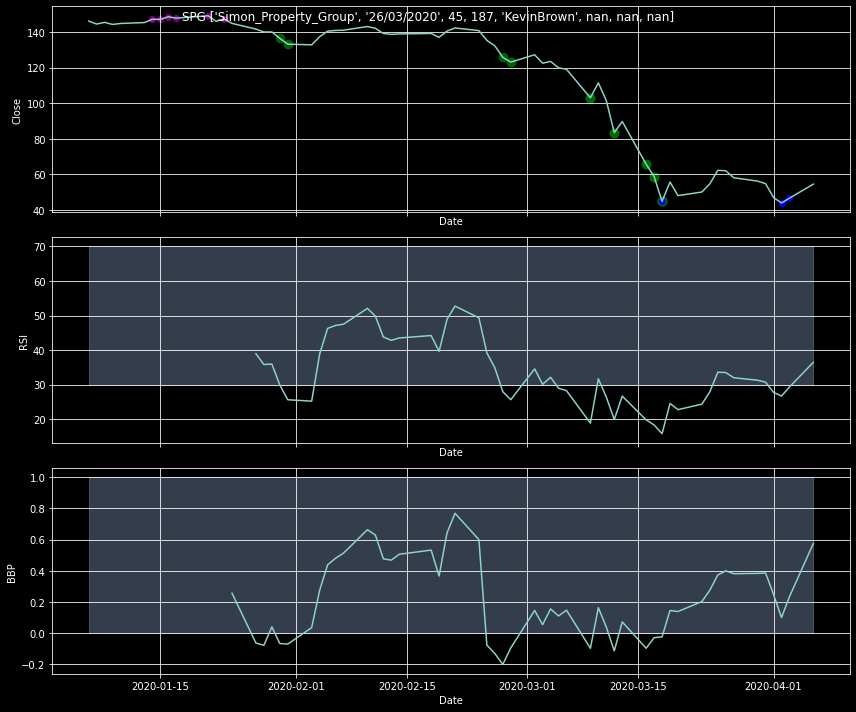

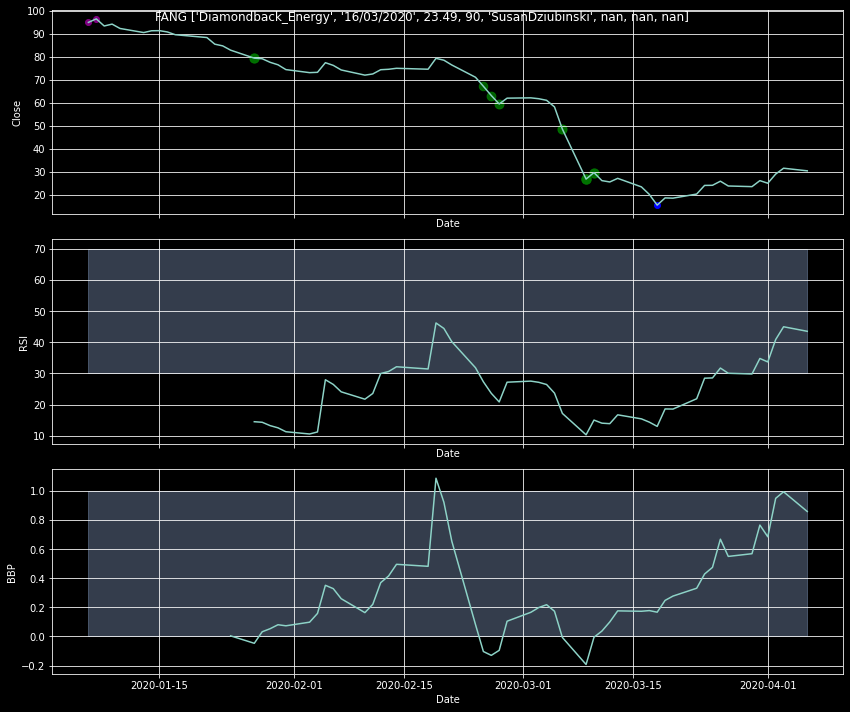

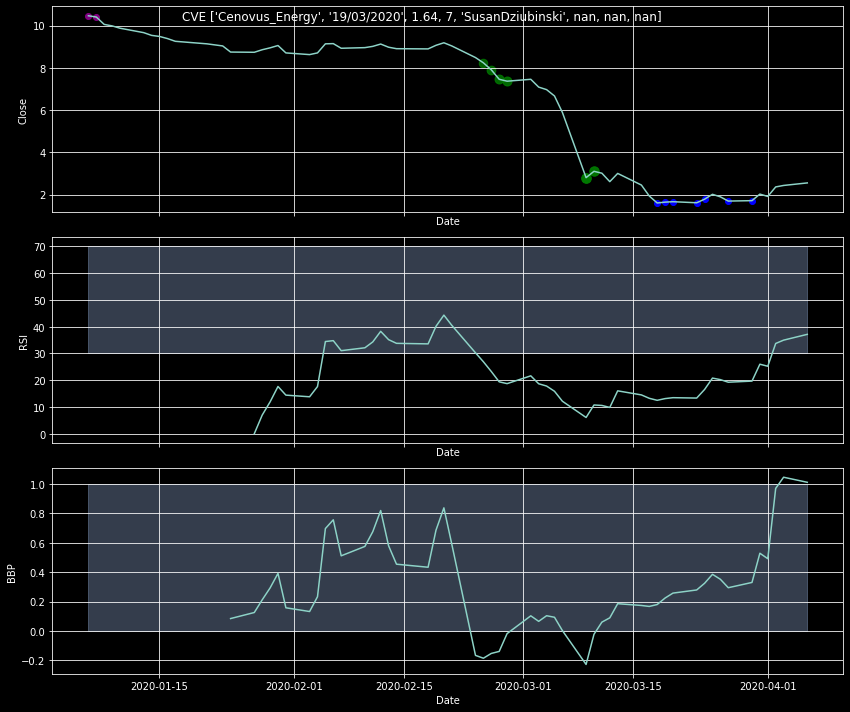

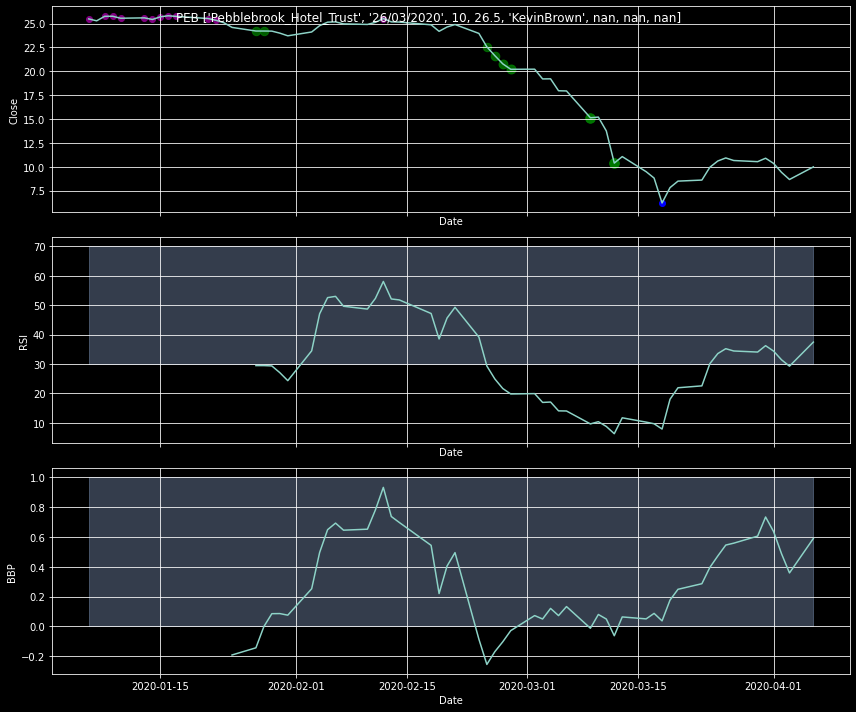

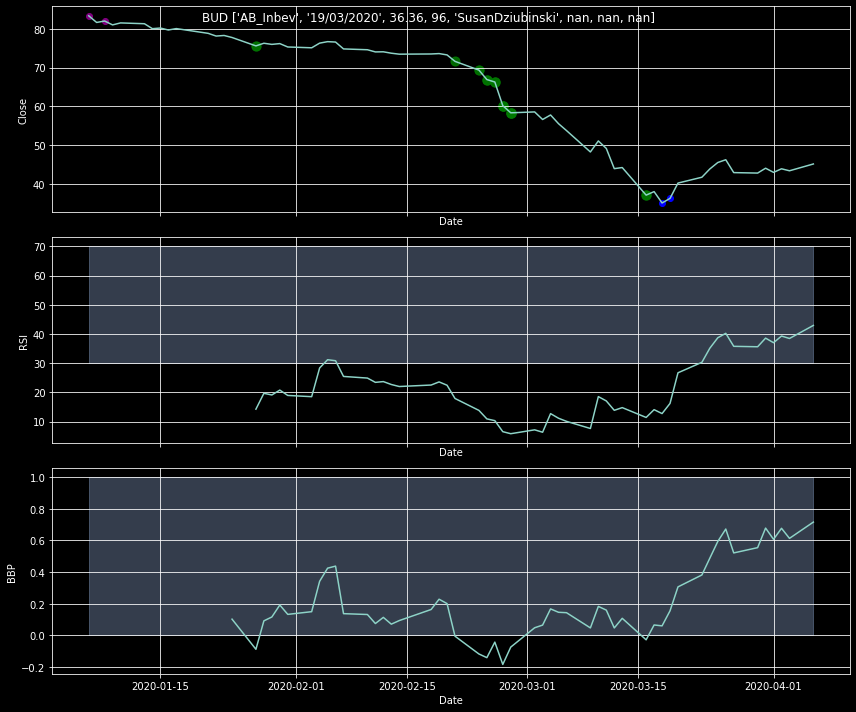

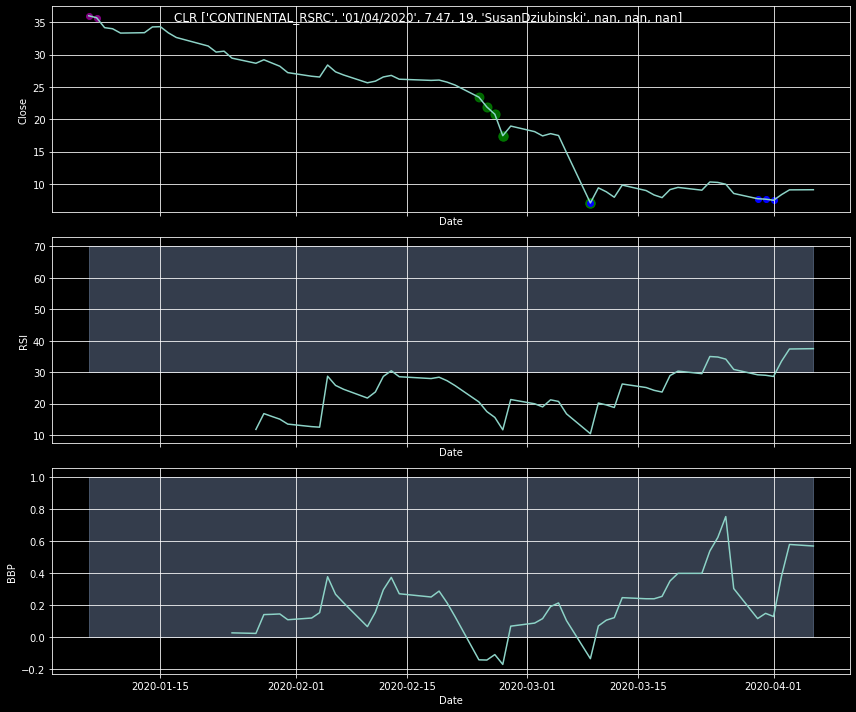

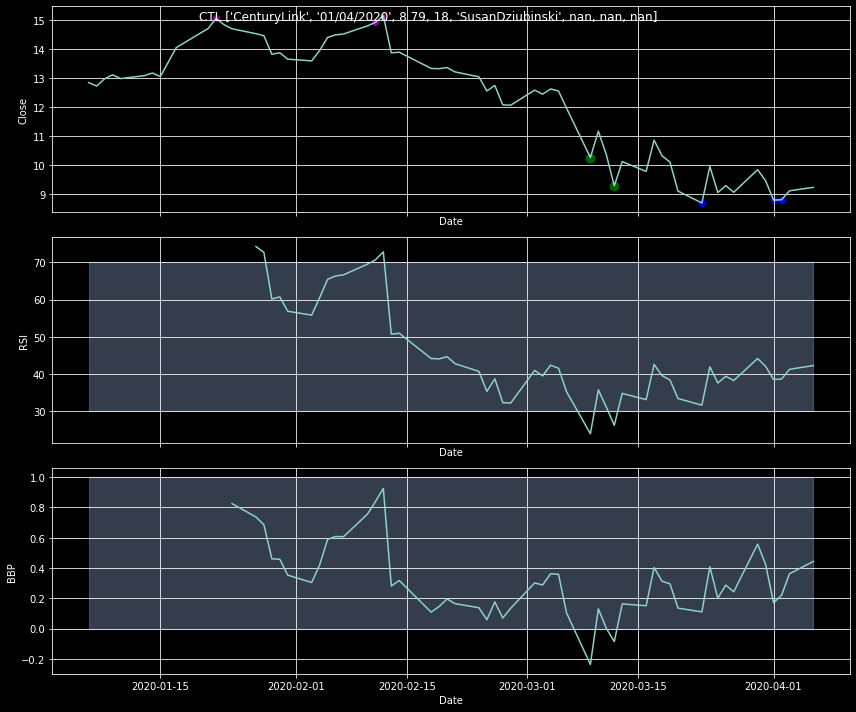

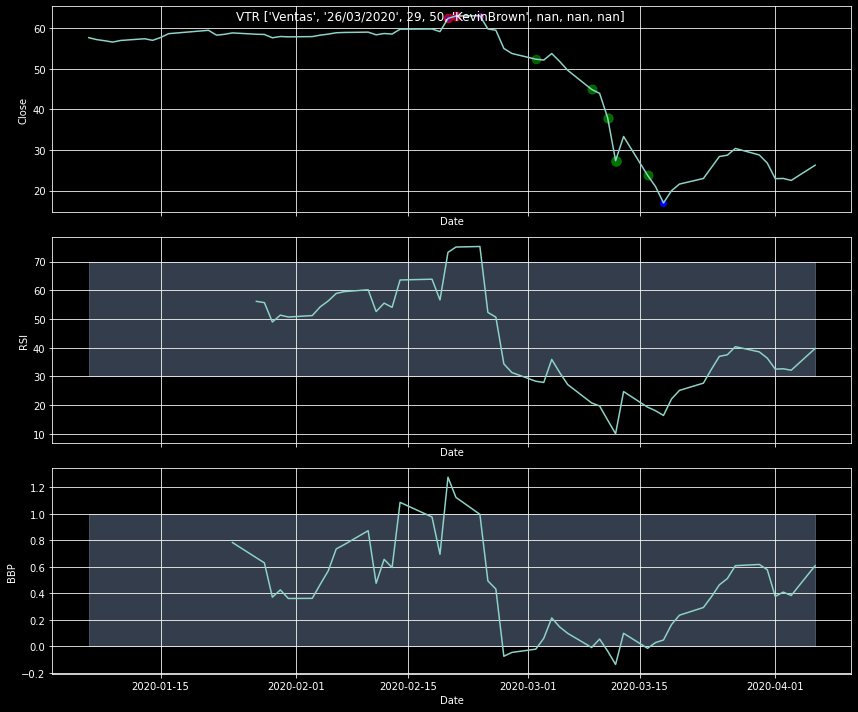

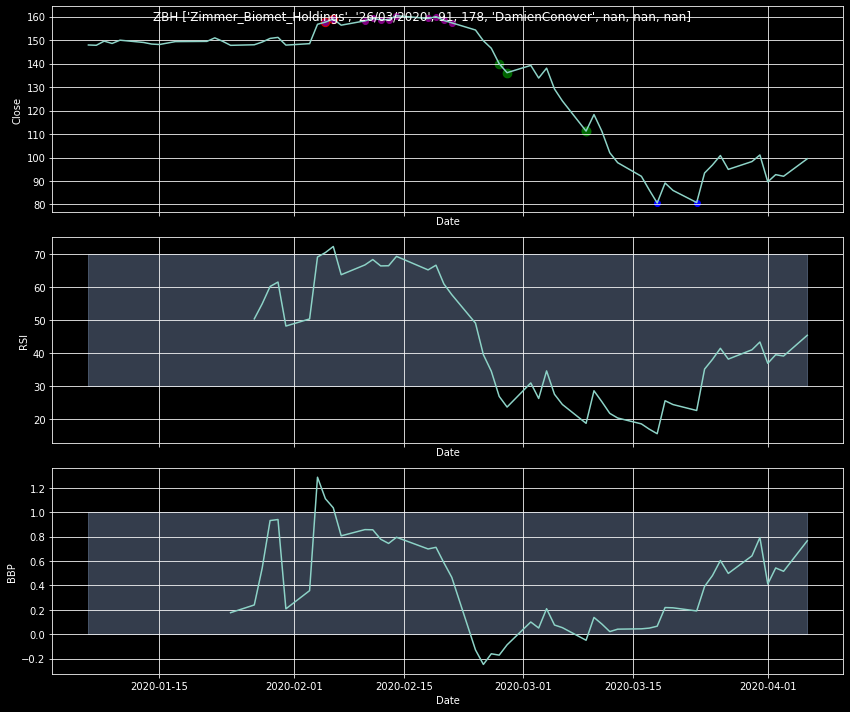

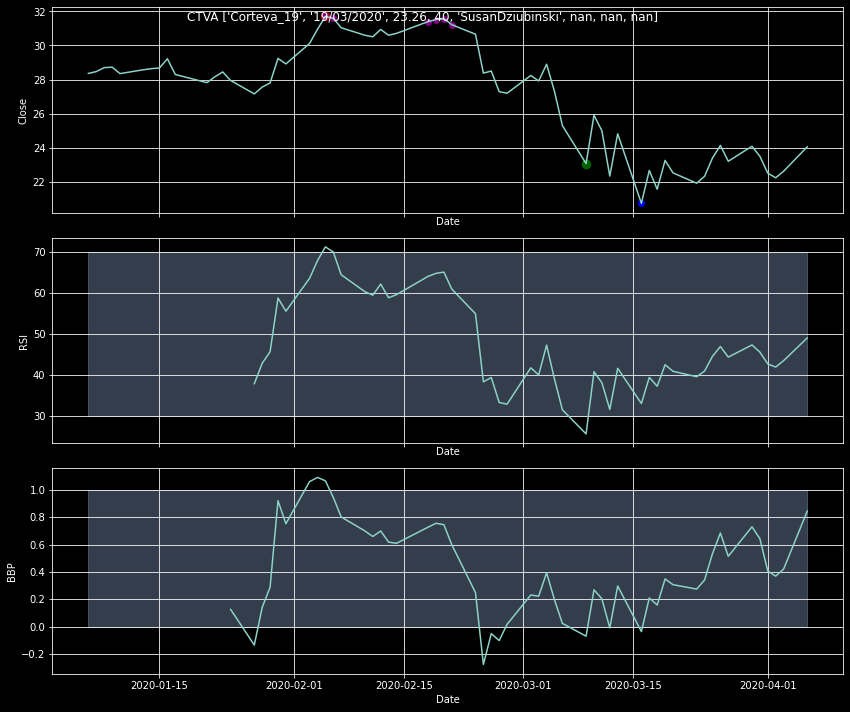

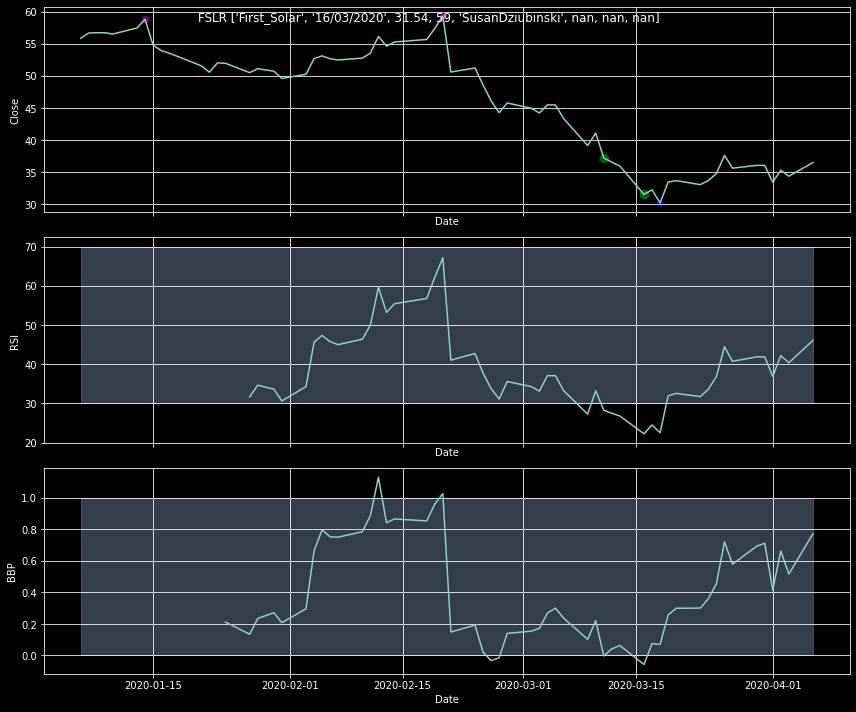

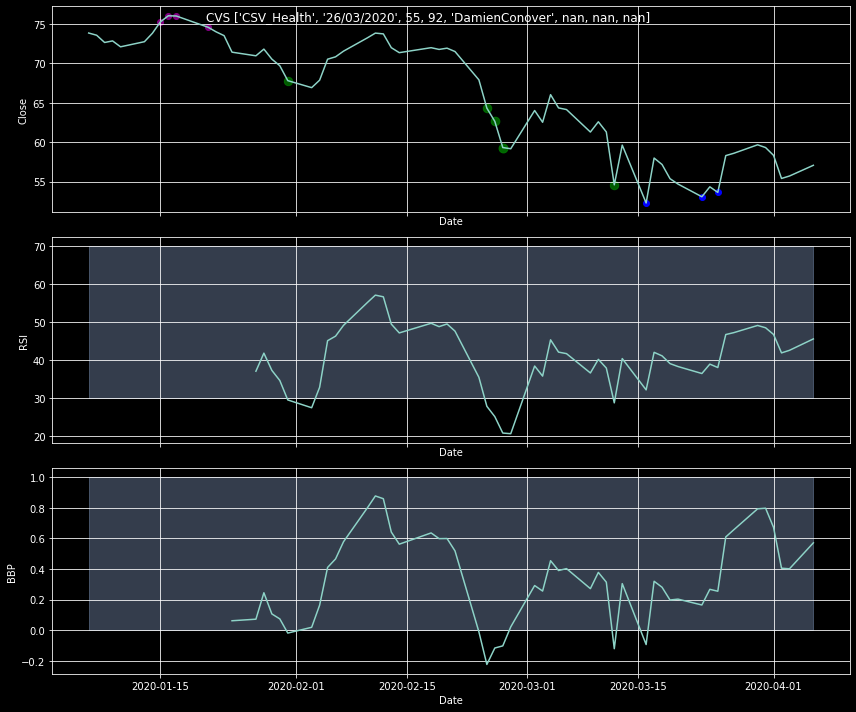

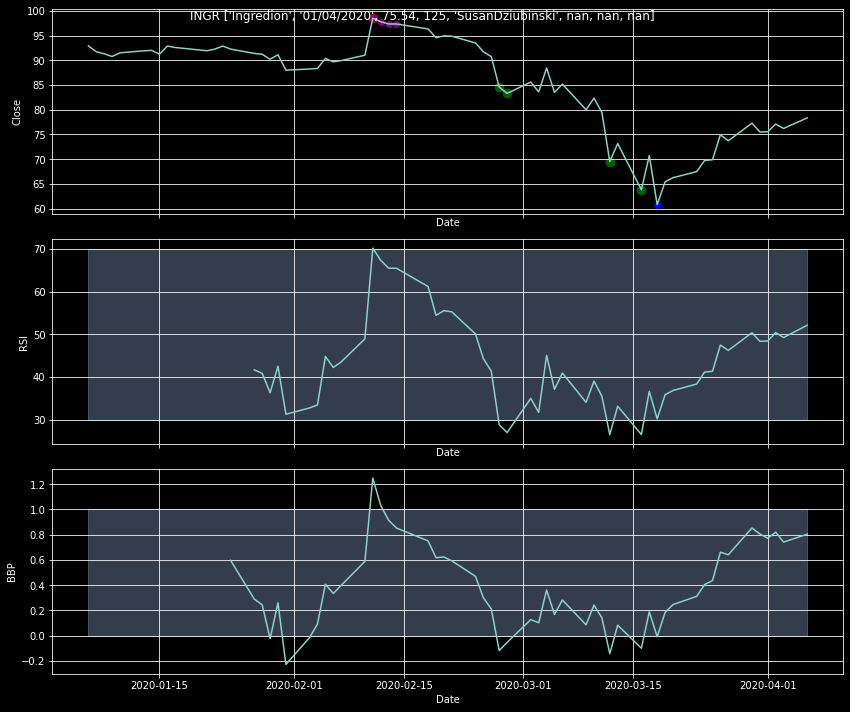

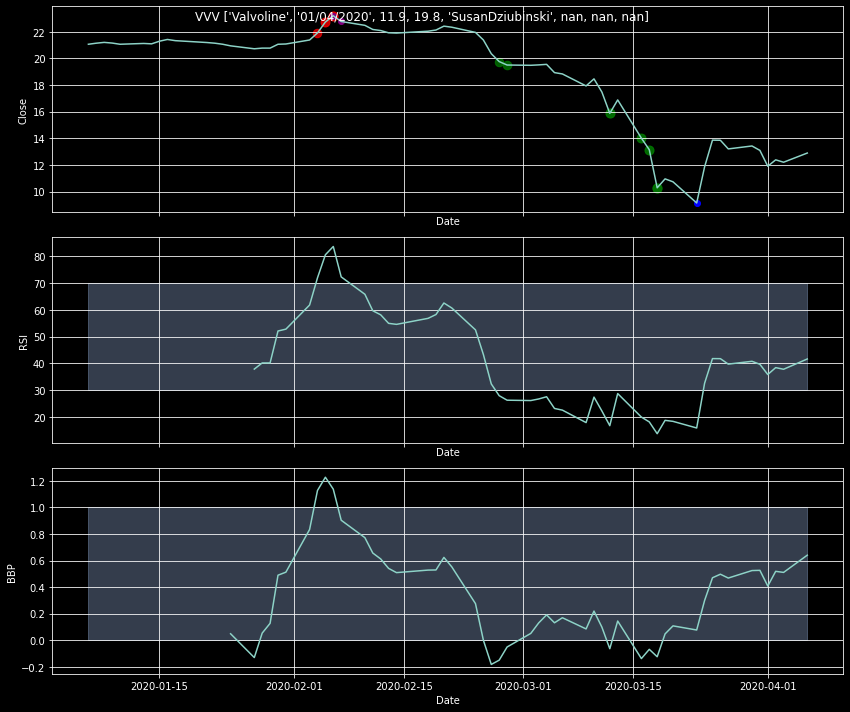

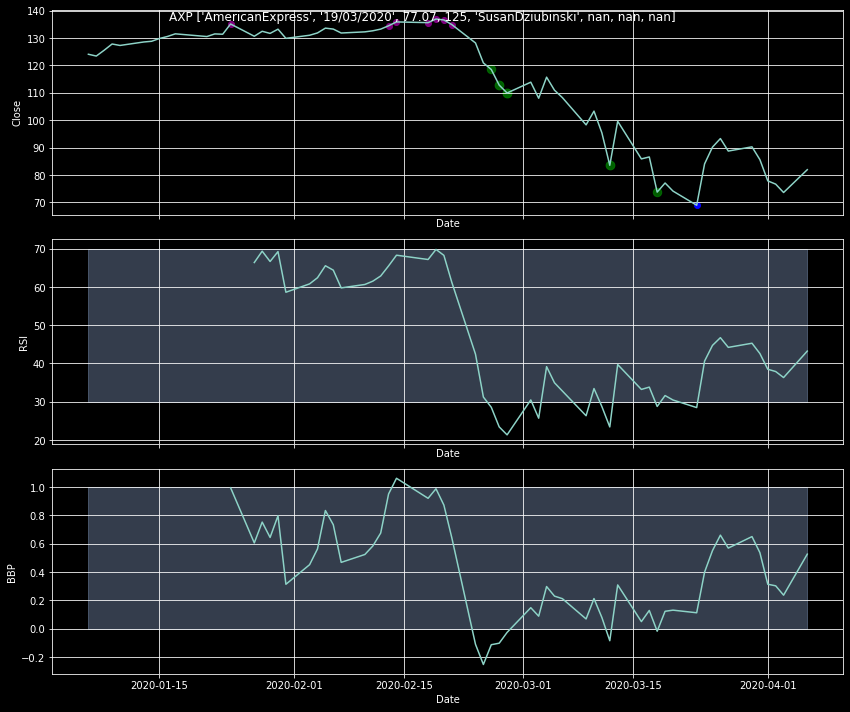

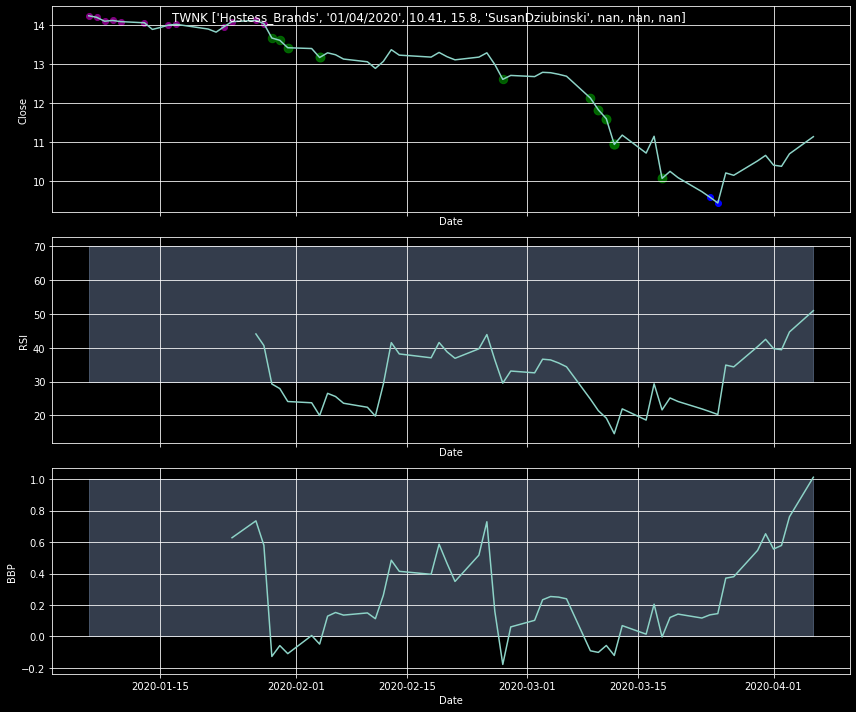

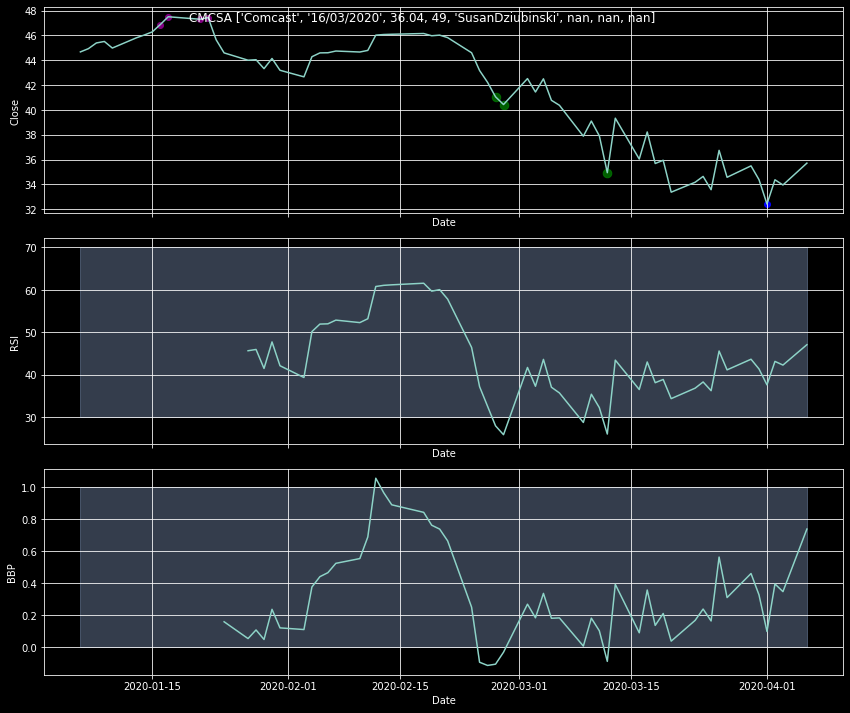

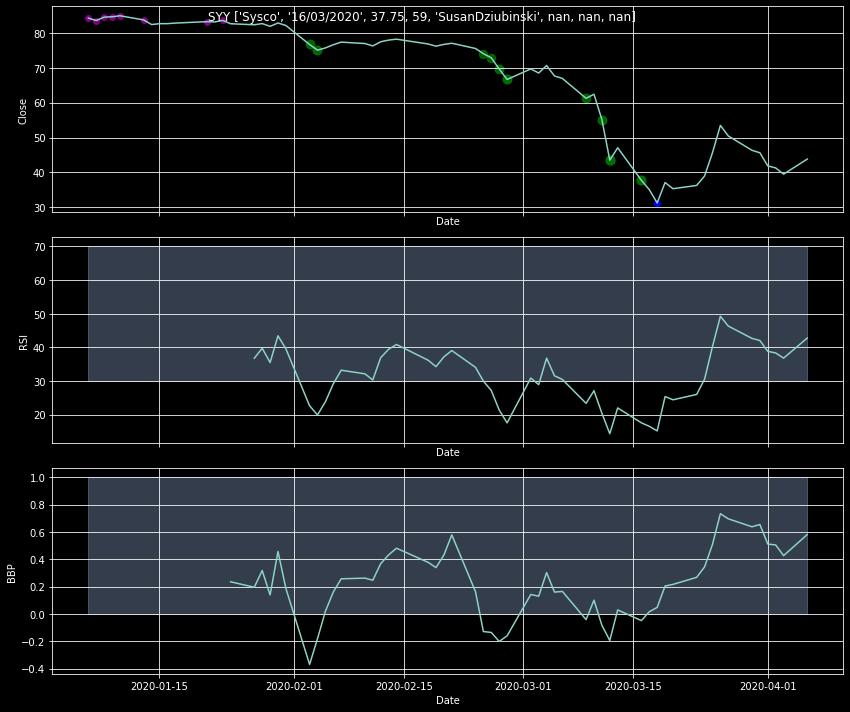

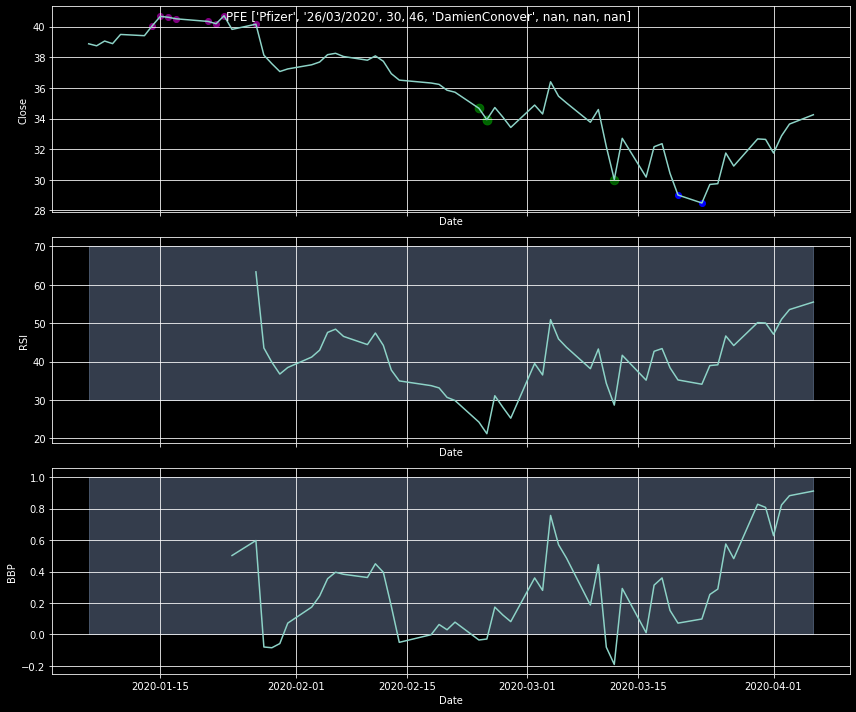

BLOW_SHIGH ['SPG', 'CLR', 'CTL', 'CMCSA']
HOLDINGS []


In [0]:
"""Display results"""
interesting_labels_BLOW_SHIGH = []
interesting_labels_HOLDINGS = []
for tick in df.index.to_list():
    # BLOW_SHIGH
    bl = hist[tick, 'BLOW_SHIGH']
    filter_bl = bl.tail(5)
    if filter_bl.any() != 0:
        #display(bl[bl != 0])
        interesting_labels_BLOW_SHIGH.append(tick)
        #plot_result(df=hist, ticker=tick, config_limits=config_limits, tickers_desc=tickers_desc)
    # HOLDINGS
    hl = hist[tick, 'HOLDINGS']
    filter_hl = hl.tail(10)
    if filter_hl.any() != 0:
        #display(hl[hl != 0])
        interesting_labels_HOLDINGS.append(tick)
        #plot_result(df=hist, ticker=tick, config_limits=config_limits, tickers_desc=tickers_desc)
    plot_result(df=hist, ticker=tick, config_limits=config_limits, tickers_desc=tickers_desc)
print('BLOW_SHIGH', interesting_labels_BLOW_SHIGH)
print('HOLDINGS', interesting_labels_HOLDINGS)

In [0]:
"""Display results"""
interesting_labels = []
for tick in tickers_desc.keys():
    hl = hist[tick, 'HOLDINGS']
    filter_hl = hl.tail(10)
    if filter_hl.any() != 0:
        #display(hl[hl != 0])
        interesting_labels.append(tick)
        #plot_result(df=hist, ticker=tick, config_limits=config_limits, tickers_desc=tickers_desc)
print(interesting_labels)

[]


In [0]:
# # Show overlap functions
# overlap_functions = ['DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA_mama', 'MAMA_fama', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA']
# for func in overlap_functions:
#     plt.figure(figsize=(14,4))
#     plt.title(func)
#     plt.grid()
#     plt.plot(hist['ASTC', func])
#     plt.plot(hist['ASTC', 'Close'])
#     # Show/save figure as desired.
#     plt.show()

In [0]:
# from talib import CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE, CDL3LINESTRIKE, CDL3OUTSIDE, CDL3STARSINSOUTH, CDL3WHITESOLDIERS, CDLABANDONEDBABY, CDLADVANCEBLOCK, CDLBELTHOLD, CDLBREAKAWAY, CDLCLOSINGMARUBOZU, CDLCONCEALBABYSWALL, CDLCOUNTERATTACK, CDLDARKCLOUDCOVER, CDLDOJI, CDLDOJISTAR, CDLDRAGONFLYDOJI, CDLENGULFING, CDLEVENINGDOJISTAR, CDLEVENINGSTAR, CDLGAPSIDESIDEWHITE, CDLGRAVESTONEDOJI, CDLHAMMER, CDLHANGINGMAN, CDLHARAMI, CDLHARAMICROSS, CDLHIGHWAVE, CDLHIKKAKE, CDLHIKKAKEMOD, CDLHOMINGPIGEON, CDLIDENTICAL3CROWS, CDLINNECK, CDLINVERTEDHAMMER, CDLKICKING, CDLKICKINGBYLENGTH, CDLLADDERBOTTOM, CDLLONGLEGGEDDOJI, CDLLONGLINE, CDLMARUBOZU, CDLMATCHINGLOW, CDLMATHOLD, CDLMORNINGDOJISTAR, CDLMORNINGSTAR, CDLONNECK, CDLPIERCING, CDLRICKSHAWMAN, CDLRISEFALL3METHODS, CDLSEPARATINGLINES, CDLSHOOTINGSTAR, CDLSHORTLINE, CDLSPINNINGTOP, CDLSTALLEDPATTERN, CDLSTICKSANDWICH, CDLTAKURI, CDLTASUKIGAP, CDLTHRUSTING, CDLTRISTAR, CDLUNIQUE3RIVER, CDLUPSIDEGAP2CROWS, CDLXSIDEGAP3METHODS

# patterns = [CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE, CDL3LINESTRIKE, CDL3OUTSIDE, CDL3STARSINSOUTH, CDL3WHITESOLDIERS, CDLABANDONEDBABY, CDLADVANCEBLOCK, CDLBELTHOLD, CDLBREAKAWAY, CDLCLOSINGMARUBOZU, CDLCONCEALBABYSWALL, CDLCOUNTERATTACK, CDLDARKCLOUDCOVER, CDLDOJI, CDLDOJISTAR, CDLDRAGONFLYDOJI, CDLENGULFING, CDLEVENINGDOJISTAR, CDLEVENINGSTAR, CDLGAPSIDESIDEWHITE, CDLGRAVESTONEDOJI, CDLHAMMER, CDLHANGINGMAN, CDLHARAMI, CDLHARAMICROSS, CDLHIGHWAVE, CDLHIKKAKE, CDLHIKKAKEMOD, CDLHOMINGPIGEON, CDLIDENTICAL3CROWS, CDLINNECK, CDLINVERTEDHAMMER, CDLKICKING, CDLKICKINGBYLENGTH, CDLLADDERBOTTOM, CDLLONGLEGGEDDOJI, CDLLONGLINE, CDLMARUBOZU, CDLMATCHINGLOW, CDLMATHOLD, CDLMORNINGDOJISTAR, CDLMORNINGSTAR, CDLONNECK, CDLPIERCING, CDLRICKSHAWMAN, CDLRISEFALL3METHODS, CDLSEPARATINGLINES, CDLSHOOTINGSTAR, CDLSHORTLINE, CDLSPINNINGTOP, CDLSTALLEDPATTERN, CDLSTICKSANDWICH, CDLTAKURI, CDLTASUKIGAP, CDLTHRUSTING, CDLTRISTAR, CDLUNIQUE3RIVER, CDLUPSIDEGAP2CROWS, CDLXSIDEGAP3METHODS]
# patterns_names = ['CDL2CROWS - Two Crows', 'CDL3BLACKCROWS - Three Black Crows', 'CDL3INSIDE - Three Inside Up/Down', 'CDL3LINESTRIKE - Three-Line Strike', 'CDL3OUTSIDE - Three Outside Up/Down', 'CDL3STARSINSOUTH - Three Stars In The South', 'CDL3WHITESOLDIERS - Three Advancing White Soldiers', 'CDLABANDONEDBABY - Abandoned Baby', 'CDLADVANCEBLOCK - Advance Block', 'CDLBELTHOLD - Belt-hold', 'CDLBREAKAWAY - Breakaway', 'CDLCLOSINGMARUBOZU - Closing Marubozu', 'CDLCONCEALBABYSWALL - Concealing Baby Swallow', 'CDLCOUNTERATTACK - Counterattack', 'CDLDARKCLOUDCOVER - Dark Cloud Cover', 'CDLDOJI - Doji', 'CDLDOJISTAR - Doji Star', 'CDLDRAGONFLYDOJI - Dragonfly Doji', 'CDLENGULFING - Engulfing Pattern', 'CDLEVENINGDOJISTAR - Evening Doji Star', 'CDLEVENINGSTAR - Evening Star', 'CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines', 'CDLGRAVESTONEDOJI - Gravestone Doji', 'CDLHAMMER - Hammer', 'CDLHANGINGMAN - Hanging Man', 'CDLHARAMI - Harami Pattern', 'CDLHARAMICROSS - Harami Cross Pattern', 'CDLHIGHWAVE - High-Wave Candle', 'CDLHIKKAKE - Hikkake Pattern', 'CDLHIKKAKEMOD - Modified Hikkake Pattern', 'CDLHOMINGPIGEON - Homing Pigeon', 'CDLIDENTICAL3CROWS - Identical Three Crows', 'CDLINNECK - In-Neck Pattern', 'CDLINVERTEDHAMMER - Inverted Hammer', 'CDLKICKING - Kicking', 'CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu', 'CDLLADDERBOTTOM - Ladder Bottom', 'CDLLONGLEGGEDDOJI - Long Legged Doji', 'CDLLONGLINE - Long Line Candle', 'CDLMARUBOZU - Marubozu', 'CDLMATCHINGLOW - Matching Low', 'CDLMATHOLD - Mat Hold', 'CDLMORNINGDOJISTAR - Morning Doji Star', 'CDLMORNINGSTAR - Morning Star', 'CDLONNECK - On-Neck Pattern', 'CDLPIERCING - Piercing Pattern', 'CDLRICKSHAWMAN - Rickshaw Man', 'CDLRISEFALL3METHODS - Rising/Falling Three Methods', 'CDLSEPARATINGLINES - Separating Lines', 'CDLSHOOTINGSTAR - Shooting Star', 'CDLSHORTLINE - Short Line Candle', 'CDLSPINNINGTOP - Spinning Top', 'CDLSTALLEDPATTERN - Stalled Pattern', 'CDLSTICKSANDWICH - Stick Sandwich', 'CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)', 'CDLTASUKIGAP - Tasuki Gap', 'CDLTHRUSTING - Thrusting Pattern', 'CDLTRISTAR - Tristar Pattern', 'CDLUNIQUE3RIVER - Unique 3 River', 'CDLUPSIDEGAP2CROWS - Upside Gap Two Crows', 'CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Method']

# for patt, patt_name in zip(patterns, patterns_names):
#     integer = patt(hist['Open', stock_symbol], 
#                     hist['High', stock_symbol], 
#                     hist['Low', stock_symbol], 
#                     hist['Close', stock_symbol])
#     if len(integer.tail(2).unique()) > 1:
#         print(patt_name)
#         print(integer.tail(2))

In [0]:
# import talib

# print(talib.get_functions())

# for key,value in talib.get_function_groups().items():
#   print(key,value)

In [0]:
# BLOW_SHIGH = ['T', 'SAN', 'BBVA', 'CAIXY']
# HOLDINGS = ['ASTC', 'T', 'ZM']
# tickerData = yf.Ticker("ZM")
# display(tickerData.recommendations)